### 1 - Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

### 2 - Defining Skill Catalog

In [2]:
# Load skill and effects data
with open("../Ambient Data/skill_and_effects.yaml", "r", encoding="utf-8") as file:
    skill_and_effects_data = yaml.safe_load(file)

SKILL_CATALOG = skill_and_effects_data["skill_catalog"]
EFFECT_RULESET = skill_and_effects_data["effect_ruleset"]
BASE_SKILL_POINTS = skill_and_effects_data["base_skill_points"]
CD_MULTIPLIERS = skill_and_effects_data["cd_multipliers"]
EFFECT_COSTS = skill_and_effects_data["effect_costs"]

# Load equipment catalog data
with open("../Ambient Data/equipment_catalog.yaml", "r", encoding="utf-8") as file:
    equipment_catalog_data = yaml.safe_load(file)

EQUIPMENT_CATALOG = equipment_catalog_data["equipment_catalog"]

# Load enemies and events data
with open("../Ambient Data/enemies_and_events.yaml", "r", encoding="utf-8") as file:
    enemies_and_events_data = yaml.safe_load(file)

ENEMIES_CATALOG = enemies_and_events_data["pools"]["enemies"]

### 4 - Defining Skill Catalog

In [3]:
def calculate_skill_power(skill_info):
    """Calculates the total Skill Points (SP) cost of a skill."""
    
    damage_cost = skill_info['damage']  # Base cost: 1 SP per damage point
    
    effect_cost = 0
    for tag in skill_info['tags']:
        effect_cost += EFFECT_COSTS.get(tag, 0)

    # Total impact is the sum of damage and effects
    total_impact = damage_cost + effect_cost
    
    # Apply cooldown "discount"
    cd_multiplier = CD_MULTIPLIERS.get(skill_info['cd'], 0.1)  # Default low value for high CDs
    
    final_power = total_impact * cd_multiplier
    
    return final_power

### 5 - Skill Power Analysis

In [4]:
def analyze_static_power(catalog):
    """Creates a DataFrame analyzing the power of each skill in the catalog."""
    
    analysis_data = []
    for name, info in catalog.items():
        power = calculate_skill_power(info)
        info['name'] = name
        info['calculated_power'] = power
        # Calculates how much the skill deviates from the base value
        info['deviation_%'] = ((power / BASE_SKILL_POINTS) - 1) * 100
        analysis_data.append(info)
        
    df_analysis = pd.DataFrame(analysis_data)
    df_analysis = df_analysis[['name', 'damage', 'cd', 'tags', 'calculated_power', 'deviation_%']]
    
    return df_analysis.sort_values(by='calculated_power', ascending=False)


# Running static analysis
df_skill_power = analyze_static_power(SKILL_CATALOG)

print("Static Power Analysis of Skills")
from IPython.display import display
display(df_skill_power)

Static Power Analysis of Skills


,name,damage,cd,tags,calculated_power,deviation_%
17,Blade of Chaos,20,2,"[Damage, Debuff, Vulnerable]",20.4,104.0
12,Thunder Clap,15,2,"[Damage, Stun]",18.0,80.0
11,Shield Bash,8,2,"[Damage, Stun]",13.8,38.0
4,Shadow Strike,25,3,"[Damage, Physical, Stealth]",12.4,24.0
2,Heavy Blow,25,3,"[Damage, Physical]",10.0,0.0
1,Quick Strike,10,1,"[Damage, Physical]",10.0,0.0
3,Wind Slash,12,2,"[Damage, Physical, Knockback]",9.6,-4.0
14,Ice Spike,18,3,"[Damage, Slow]",9.2,-8.0
13,Frostbite,10,2,"[Damage, Slow]",9.0,-10.0
22,Fireball,15,2,"[Damage, DoT]",9.0,-10.0


### 6 - Combat Simulation Function

In [5]:
def simulate_combat(agent_hp, agent_equipment, agent_skills, enemy_hp, enemy_equipment, enemy_skills):
    """
    Simula um combate realista, aplicando efeitos passivos de itens, gatilhos
    on-hit, on-being-hit e efeitos especiais.
    Retorna uma tupla: (número de turnos, vencedor), onde vencedor é 1 para o agente, -1 para o inimigo.
    """
    
    # --- 1. SETUP INICIAL E APLICAÇÃO DE PASSIVOS ---
    
    def initialize_combatant(hp, equipment_names, skill_names):
        """Função auxiliar para preparar um combatente."""
        combatant = {
            'hp': hp,
            'max_hp': hp, # Armazena o HP máximo para efeitos de %
            'skills': {name: SKILL_CATALOG[name] for name in skill_names},
            'equipment': {name: EQUIPMENT_CATALOG[name] for name in equipment_names},
            'cooldowns': {s: 0 for s in skill_names},
            'effects': {},
            # Modificadores base que serão alterados pelos itens
            'damage_modifier': 1.0,
            'flat_damage_bonus': 0,
            'damage_reduction': 0.0,
            'crit_chance': 0.0,
            'dot_potency_modifier': 1.0,
            'on_hit_effects': [],
            'on_being_hit_effects': [],
            'special_effects': {} # Para efeitos únicos como Revive
        }

        # Aplica os bônus passivos dos itens
        for item_info in combatant['equipment'].values():
            for effect, value in item_info.get('passive_effects', {}).items():
                if effect == 'flat_hp_bonus':
                    combatant['hp'] += value
                    combatant['max_hp'] += value
                elif effect == 'damage_modifier':
                    combatant['damage_modifier'] += value
                elif effect == 'flat_damage_bonus':
                    combatant['flat_damage_bonus'] += value
                elif effect == 'damage_reduction':
                    combatant['damage_reduction'] += value
                elif effect == 'crit_chance':
                    combatant['crit_chance'] += value
                elif effect == 'dot_potency_modifier':
                    combatant['dot_potency_modifier'] += value

            if 'on_hit_effect' in item_info:
                combatant['on_hit_effects'].append(item_info['on_hit_effect'])
            if 'on_being_hit_effect' in item_info:
                combatant['on_being_hit_effects'].append(item_info['on_being_hit_effect'])
            if 'special_effect' in item_info:
                if item_info['special_effect'] == 'Revive':
                    combatant['special_effects']['Revive'] = {'used': False, 'potency': EFFECT_RULESET['Revive']['potency']}

        return combatant

    agent = initialize_combatant(agent_hp, agent_equipment, agent_skills)
    enemy = initialize_combatant(enemy_hp, enemy_equipment, enemy_skills)
    
    turn = 0
    combatants = [agent, enemy]
    max_turns = 200

    # --- 2. LOOP DE COMBATE ---
    while agent['hp'] > 0 and enemy['hp'] > 0 and turn < max_turns:
        turn += 1
        
        attacker = combatants[(turn - 1) % 2]
        defender = combatants[turn % 2]

        # --- FASE DE INÍCIO DE TURNO (Processar Efeitos Ativos) ---
        active_effects = list(attacker['effects'].keys())
        is_stunned = False
        for effect_name in active_effects:
            if effect_name not in attacker['effects']: continue
            rule = EFFECT_RULESET.get(effect_name, {})
            if rule.get('type') == 'DoT':
                dot_damage = rule.get('damage_per_turn', 0) * attacker.get('dot_potency_modifier', 1.0)
                attacker['hp'] -= dot_damage
            if rule.get('type') == 'Control' and effect_name in ['Stun', 'Fear']:
                is_stunned = True
            attacker['effects'][effect_name]['duration'] -= 1
            if attacker['effects'][effect_name]['duration'] <= 0:
                del attacker['effects'][effect_name]
        if attacker['hp'] <= 0: break
        if is_stunned: continue

        # --- FASE DE AÇÃO ---
        available_skills = [s for s, cd in attacker['cooldowns'].items() if s != 'Wait']
        available_actions = available_skills + ['Wait']
        
        action_name = np.random.choice(available_actions)

        if action_name == 'Wait':
            pass
        else:
            skill_info = attacker['skills'][action_name]
            
            # --- CÁLCULO DE DANO COMPLETO ---
            base_damage = skill_info.get('damage', 0)
            effect_damage_mod = 1.0 + attacker['effects'].get('Buff_Self_Damage', {}).get('stat_modifier', {}).get('damage_output', 0.0)
            effect_defense_mod = 1.0 + defender['effects'].get('Vulnerable', {}).get('stat_modifier', {}).get('defense_taken', 0.0)
            item_damage_mod = attacker.get('damage_modifier', 1.0)
            item_defense_mod = 1.0 - defender.get('damage_reduction', 0.0)
            is_crit = np.random.rand() < attacker.get('crit_chance', 0.0)
            crit_modifier = 2.0 if is_crit else 1.0
            final_damage = (base_damage + attacker.get('flat_damage_bonus', 0)) * item_damage_mod * effect_damage_mod * crit_modifier
            final_damage_taken = final_damage * item_defense_mod * effect_defense_mod

            # --- APLICAÇÃO DE DANO E EFEITOS ---
            if base_damage < 0:
                attacker['hp'] -= base_damage
            else:
                defender['hp'] -= final_damage_taken
                
                # Aplica efeitos ON-HIT do atacante
                for on_hit in attacker['on_hit_effects']:
                    if np.random.rand() < on_hit['chance']:
                        tag = on_hit['effect_tag']
                        if tag in EFFECT_RULESET:
                            defender['effects'][tag] = {'duration': EFFECT_RULESET[tag]['duration']}
                
                # Aplica efeitos ON-BEING-HIT do defensor
                if defender['hp'] > 0:
                    for on_being_hit in defender['on_being_hit_effects']:
                        if np.random.rand() < on_being_hit['chance']:
                            tag = on_being_hit['effect_tag']
                            if tag == 'Reflect':
                                attacker['hp'] -= final_damage_taken * EFFECT_RULESET['Reflect']['potency']
                            elif tag in EFFECT_RULESET:
                                attacker['effects'][tag] = {'duration': EFFECT_RULESET[tag]['duration']}

            # Aplica efeitos da skill usada
            for tag in skill_info['tags']:
                if tag in EFFECT_RULESET:
                    rule = EFFECT_RULESET[tag]
                    target = attacker if rule.get('target') == 'Self' else defender
                    target['effects'][tag] = {'duration': rule['duration']}
            
            attacker['cooldowns'][action_name] = skill_info['cd']

        # --- FIM DO TURNO ---
        for skill in attacker['cooldowns']:
            if attacker['cooldowns'][skill] > 0:
                attacker['cooldowns'][skill] -= 1
        
        if attacker['hp'] <= 0 and attacker['special_effects'].get('Revive', {}).get('used') == False:
            revive_rule = attacker['special_effects']['Revive']
            attacker['hp'] = attacker['max_hp'] * revive_rule['potency']
            revive_rule['used'] = True

    # --- 3. DETERMINAÇÃO DO VENCEDOR ---
    winner = 0 # Empate (se atingir max_turns)
    if agent['hp'] > 0 and enemy['hp'] <= 0:
        winner = 1 # Agente venceu
    elif enemy['hp'] > 0 and agent['hp'] <= 0:
        winner = -1 # Inimigo venceu
        
    return (turn, winner)

### 7 - Simulation Result

--- Testando contra: Cursed Knight (HP: 130) ---


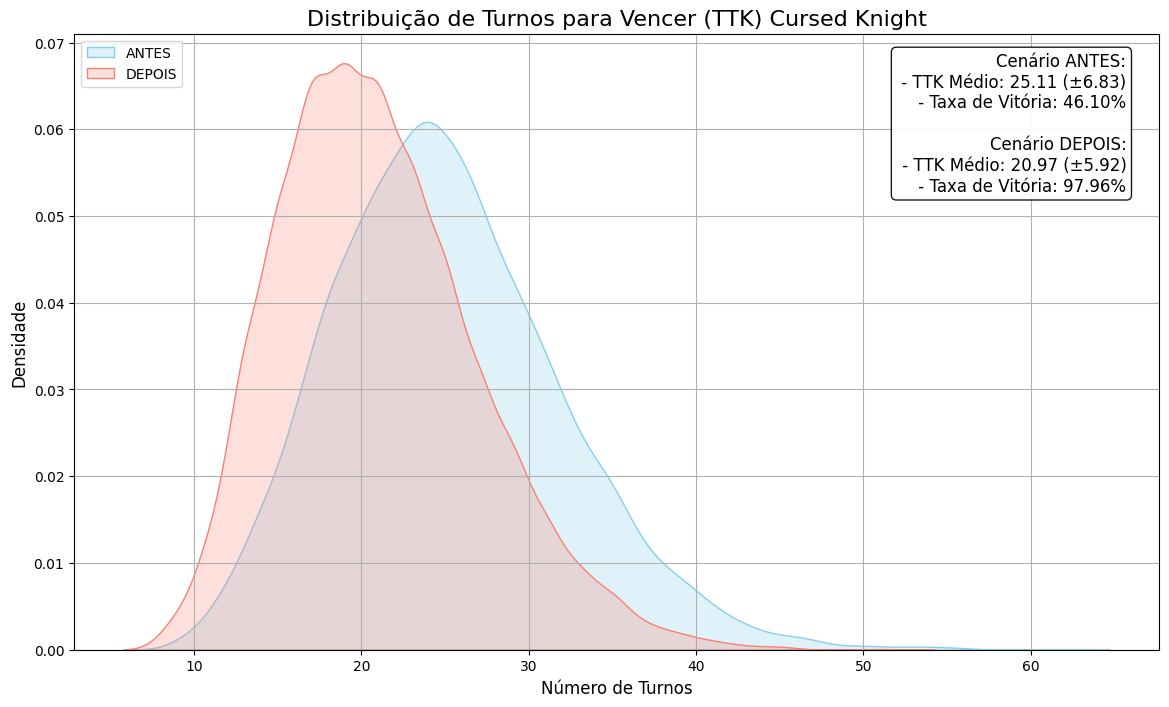

In [ ]:
# Running the realistic simulations
n_simulations = 5000

# HP for combat simulation
BASE_ENTITY_HP = 200

# Nome do inimigo a ser testado
ENEMY_NAME_TO_TEST = 'Cursed Knight'

# Busca os dados do inimigo selecionado no catálogo
try:
    enemy_data = ENEMIES_CATALOG[ENEMY_NAME_TO_TEST]
    ENEMY_HP = enemy_data['hp']
    ENEMY_SKILLS = enemy_data['skills']
    ENEMY_EQUIPMENT = enemy_data['equipment']
    print(f"--- Testando contra: {ENEMY_NAME_TO_TEST} (HP: {ENEMY_HP}) ---")
except KeyError:
    print(f"ERRO: Inimigo '{ENEMY_NAME_TO_TEST}' não encontrado no catálogo!")
    # Você pode parar a execução ou usar um inimigo padrão aqui
    ENEMY_HP, ENEMY_SKILLS, ENEMY_EQUIPMENT = 0, [], []

# Equipamento e habilidades do agente antes e depois da mudança
AGENT_HP = 100 # HP do agente

AGENT_SKILLS_BEFORE  = ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait']
AGENT_SKILLS_AFTER =   ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait']
AGENT_EQUIPMENT_BEFORE  = ['Shortsword', 'Leather Tunic', 'Tome of Haste']
AGENT_EQUIPMENT_AFTER  = ['Blade of the Martyr', 'Bulwark of the Saint', 'Poisoner\'s Talisman']

# Simula o combate
results_before = [simulate_combat(AGENT_HP, AGENT_EQUIPMENT_BEFORE, AGENT_SKILLS_BEFORE, ENEMY_HP, ENEMY_EQUIPMENT, ENEMY_SKILLS) for _ in range(n_simulations)]
results_after = [simulate_combat(AGENT_HP, AGENT_EQUIPMENT_AFTER, AGENT_SKILLS_AFTER, ENEMY_HP, ENEMY_EQUIPMENT, ENEMY_SKILLS) for _ in range(n_simulations)]

# Processa os resultados
ttk_before = [r[0] for r in results_before]
wins_before = sum(1 for r in results_before if r[1] == 1)
win_rate_before = (wins_before / n_simulations) * 100

ttk_after = [r[0] for r in results_after]
wins_after = sum(1 for r in results_after if r[1] == 1)
win_rate_after = (wins_after / n_simulations) * 100

# Criar o gráfico com KDE das distribuições
plt.figure(figsize=(14, 8))
sns.kdeplot(ttk_before, label='ANTES', color='skyblue', fill=True, warn_singular=False)
sns.kdeplot(ttk_after, label='DEPOIS', color='salmon', fill=True, warn_singular=False)
plt.title(f'Distribuição de Turnos para Vencer (TTK)', fontsize=16)
plt.xlabel('Número de Turnos', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.grid(True)

# Adiciona os textos com informações de TTK e Win Rate
textstr = (
    f"Cenário ANTES:\n"
    f" - TTK Médio: {np.mean(ttk_before):.2f} (±{np.std(ttk_before):.2f})\n"
    f" - Taxa de Vitória: {win_rate_before:.2f}%\n\n"
    f"Cenário DEPOIS:\n"
    f" - TTK Médio: {np.mean(ttk_after):.2f} (±{np.std(ttk_after):.2f})\n"
    f" - Taxa de Vitória: {win_rate_after:.2f}%"
)

# Define as propriedades da caixa de texto
props = dict(boxstyle='round', facecolor='white', alpha=0.9)

# Posiciona no canto superior direito (x=0.97, y=0.97 no sistema de coordenadas Axes)
plt.gca().text(0.97, 0.97, textstr, transform=plt.gca().transAxes,
               fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

plt.show()
